In [1]:
import os
import json
import sys

import numpy as np
import anndata as ad
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats

In [2]:
# User variables

PROJ_ROOT = "/home/fichtner/projects/footprintQTL"
os.chdir(PROJ_ROOT)

RNA_AD_PATH = "/omics/groups/OE0540/internal/projects/HCA_organoid_2/cemm_sabrina-20Jul2022/outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad"
CT_MAP_JSON_PATH = "config/cell-type_groupings/hca_brain-organoids/approach_2024-09-12.json"

In [3]:
os.chdir(PROJ_ROOT)

sys.path.append(os.path.join(PROJ_ROOT, "code"))
from helpers.helpers import ct_format, ct_format_alt

In [4]:
# Get ct-ann --> grouped-ct mappings
with open(CT_MAP_JSON_PATH, 'r') as f:
    ct_map = json.load(f)

# Format
ct_map = {ct_format(key): [ct_format(e) for e in listt] for key, listt in ct_map.items()}
ct_map_i = {old_ct: new_ct for new_ct, old_cts in ct_map.items() for old_ct in old_cts}

In [5]:
def p(s):
    print(s)

In [6]:
# # TMP
# PROJECT_PATH = '/home/fichtner/projects/footprintQTL'
# DATA_PATH = '/omics/groups/OE0540/internal/projects/HCA_organoid_2/cemm_sabrina-20Jul2022/'
# RNA_AD = 'outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad'

# import sys
# sys.path.append(PROJECT_PATH + "/code")
# from helpers.helpers import ct_format, get_anndata_coldata

# cells_coldata = get_anndata_coldata(os.path.join(DATA_PATH, RNA_AD))[0]
# del cells_coldata

In [7]:
# Exclude for some weird reason, samples in QC but not in other files
artifact_donors = {'SAMEA2474458', 'SAMEA2555012'}

# RNA-seq anndata

In [8]:
rna_obs = ad.read_h5ad(RNA_AD_PATH, backed='r').obs

# Remove artifact donors
donors_qc = ~rna_obs['donor_id'].isin(artifact_donors)
rna_obs = rna_obs[donors_qc].copy()
rna_obs['donor_id'] = rna_obs['donor_id'].cat.remove_unused_categories()

# Format
rna_obs['cell_type'] = rna_obs['celltype_predicted_vertesy'].apply(ct_format)
rna_obs['cell_type'] = rna_obs['cell_type'].map(ct_map_i).astype('category')

# Filter cell-types marked 'Discard'
if 'Discard' in rna_obs['cell_type'].cat.categories:
    rna_obs = rna_obs[~(rna_obs['cell_type'] == 'Discard')].copy()
    rna_obs['cell_type'] = rna_obs['cell_type'].cat.remove_categories('Discard')
    
rna_obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,...,mt_cat,ribo_cat,leiden,CellType,Batch,celltype_predicted_vertesy,stressed_vs_unstressed_celltypes,glia_neuron_celltpyes,gruffi,cell_type
AAACAGCCAACTAACT-1_sSL0082,sSL0082,2700,7.901377,6434.0,8.769507,20.049736,27.820951,37.395089,54.662729,145.0,...,Medium(Q1Q2),MediumHigh(Q2Q3),6,unknown,sabrina_sSL0082,immature EN,unstressed,Neuron linage,FALSE,Neural-progenitors
AAACAGCCAGGCAAGC-1_sSL0082,sSL0082,1995,7.598900,3782.0,8.238273,23.823374,30.988895,40.190375,57.588577,319.0,...,High(Q3Q4),MediumHigh(Q2Q3),4,unknown,sabrina_sSL0082,Glia,unstressed,Glia linage,FALSE,Glia
AAACAGCCAGGCCATT-1_sSL0082,sSL0082,1439,7.272398,2499.0,7.824046,21.088435,30.172069,41.656663,62.424970,63.0,...,Medium(Q1Q2),Low(Q1),1,unknown,sabrina_sSL0082,UL-EN,unstressed,Neuron linage,FALSE,UL-EN
AAACAGCCATTCAGCA-1_sSL0082,sSL0082,1629,7.396335,2902.0,7.973500,25.292901,32.598208,42.522398,61.095796,305.0,...,High(Q3Q4),MediumHigh(Q2Q3),4,unknown,sabrina_sSL0082,Glia,unstressed,Glia linage,FALSE,Glia
AAACATGCAACTAGCC-1_sSL0082,sSL0082,1228,7.113956,1844.0,7.520235,18.329718,26.735358,38.665944,60.520607,14.0,...,Medium(Q1Q2),MediumHigh(Q2Q3),6,unknown,sabrina_sSL0082,immature EN,unstressed,Neuron linage,FALSE,Neural-progenitors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGAAGTCACCTC-1_sSL0182,sSL0182,3195,8.069655,7622.0,8.938926,20.165311,27.223826,36.106009,51.587510,327.0,...,MediumHigh(Q2Q3),Low(Q1),9,unknown,sabrina_sSL0182,Glia,unstressed,Glia linage,FALSE,Glia
TTTGTGGCAACACTTG-1_sSL0182,sSL0182,3517,8.165648,10000.0,9.210441,23.550000,30.810000,39.520000,54.610000,69.0,...,Medium(Q1Q2),Low(Q1),7,unknown,sabrina_sSL0182,DL-EN,unstressed,Neuron linage,FALSE,DL-EN
TTTGTGGCACCACAAC-1_sSL0182,sSL0182,3283,8.096817,8621.0,9.062073,23.512354,30.019719,38.638209,54.100452,83.0,...,Medium(Q1Q2),Low(Q1),5,unknown,sabrina_sSL0182,DL-EN,unstressed,Neuron linage,FALSE,DL-EN
TTTGTTGGTTTGGGTA-1_sSL0182,sSL0182,2808,7.940584,6844.0,8.831274,23.655757,31.165985,40.298071,56.706604,1.0,...,Low(Q1),Low(Q1),5,unknown,sabrina_sSL0182,DL-EN,unstressed,Neuron linage,FALSE,DL-EN


# General

DescribeResult(nobs=72, minmax=(0, 11530), mean=2721.2638888888887, variance=6857931.6899452275, skewness=1.4373972635530166, kurtosis=1.6024660153197363)


Text(0.5, 1.0, 'Cell-count per donor')

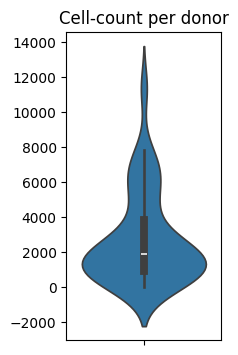

In [9]:
### By donor

donor = rna_obs.groupby(['donor']).size()

p(stats.describe(donor))

plt.figure(figsize=(2, 4))
sns.violinplot(donor)
plt.title(f"Cell-count per donor")

DescribeResult(nobs=6696, minmax=(0, 3469), mean=29.26090203106332, variance=37466.345512195934, skewness=10.104229563609703, kurtosis=124.72933014331356)


Text(0.5, 1.0, 'Cell-count per donor-batch')

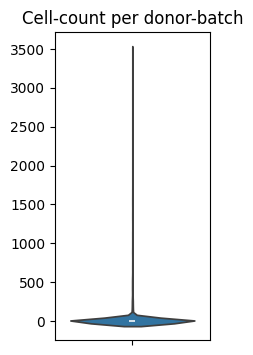

In [10]:
### By donor-batch

donor_batch = rna_obs.groupby(['donor', 'sample']).size()

p(stats.describe(donor_batch))

plt.figure(figsize=(2, 4))
sns.violinplot(donor_batch)
plt.title(f"Cell-count per donor-batch")

cell_type
DL-EN                 30210
Glia                  52409
Midbrain-EN           19332
Neural-progenitors    52780
UL-EN                 41200
dtype: int64
DescribeResult(nobs=5, minmax=(19332, 52780), mean=39186.2, variance=209612663.2, skewness=-0.34238465656414824, kurtosis=-1.3882546740742427)


Text(0.5, 1.0, 'Cell-count per cell-type')

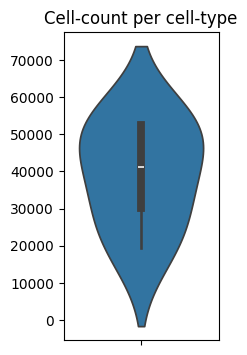

In [11]:
### By cell-type

ct = rna_obs.groupby(['cell_type']).size()

p(ct)
p(stats.describe(ct))

plt.figure(figsize=(2, 4))
sns.violinplot(ct)
plt.title(f"Cell-count per cell-type")

DescribeResult(nobs=360, minmax=(0, 4166), mean=544.2527777777777, variance=532029.292471371, skewness=1.8742549008946974, kurtosis=3.3620157208935986)


Text(0.5, 1.0, 'Cell-count per ct-donor')

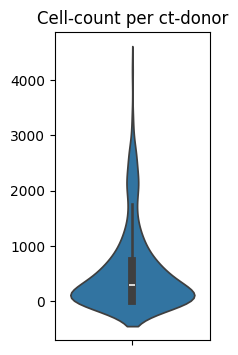

In [12]:
### By ct-donor

ct_donor = rna_obs.groupby(['donor', 'cell_type']).size()

p(stats.describe(ct_donor))

plt.figure(figsize=(2,4))
sns.violinplot(ct_donor)
plt.title(f"Cell-count per ct-donor")

DescribeResult(nobs=316, minmax=(1, 4166), mean=620.0348101265823, variance=559207.83053044, skewness=1.7310116856031823, kurtosis=2.7615286270459)


Text(0.5, 1.0, 'Cell-count per ct-donor')

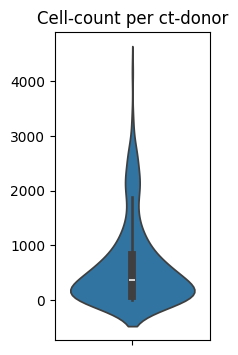

In [13]:
### By ct-donor: 0s removed

ct_donor = rna_obs.groupby(['donor', 'cell_type']).size()
ct_donor = ct_donor[ct_donor!= 0]

p(stats.describe(ct_donor))

plt.figure(figsize=(2,4))
sns.violinplot(ct_donor)
plt.title(f"Cell-count per ct-donor")

DescribeResult(nobs=465, minmax=(0, 2660), mean=421.35698924731184, variance=232111.01452539858, skewness=2.0319480585605683, kurtosis=4.505736447105985)


Text(0.5, 1.0, 'Cell-count per ct-batch')

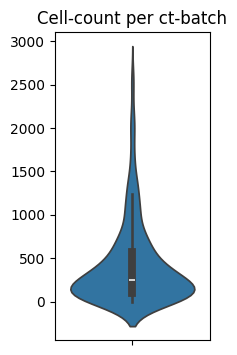

In [14]:
### By ct-batch (useful for HVPeaks assessment)

ct_batch = rna_obs.groupby(['sample', 'cell_type']).size()

p(stats.describe(ct_batch))

plt.figure(figsize=(2,4))
sns.violinplot(ct_batch)
plt.title(f"Cell-count per ct-batch")

DescribeResult(nobs=33480, minmax=(0, 1499), mean=5.852180406212664, variance=2429.1271973723933, skewness=13.714918470511314, kurtosis=247.1377178389585)


Text(0.5, 1.0, 'Cell-count per ct-donor-batch')

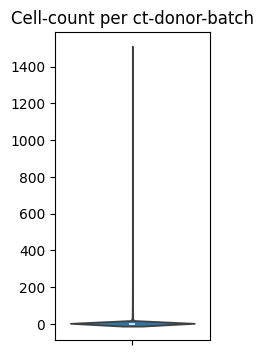

In [15]:
### By ct-donor-batch

ct_donor_batch = rna_obs.groupby(['donor', 'cell_type', 'sample']).size()

p(stats.describe(ct_donor_batch))

plt.figure(figsize=(2,4))
sns.violinplot(ct_donor_batch)
plt.title(f"Cell-count per ct-donor-batch")

DescribeResult(nobs=1393, minmax=(1, 1499), mean=140.65398420674802, variance=39448.920416945155, skewness=2.692738671636466, kurtosis=9.535444745151526)


Text(0.5, 1.0, 'Cell-count per ct-donor-batch')

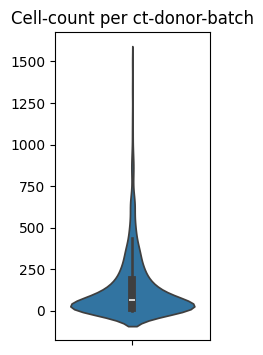

In [16]:
### By ct-donor-batch: 0s removed

ct_donor_batch = rna_obs.groupby(['donor', 'cell_type', 'sample']).size()
ct_donor_batch = ct_donor_batch[ct_donor_batch!= 0]

p(stats.describe(ct_donor_batch))

plt.figure(figsize=(2,4))
sns.violinplot(ct_donor_batch)
plt.title(f"Cell-count per ct-donor-batch")

# 1 cell-type

==> Removed 0-count donors and samples

In [17]:
cell_type = 'UL-EN'

peaks_obs_1ct = rna_obs[rna_obs['cell_type'] == cell_type].copy()
peaks_obs_1ct['donor'] = peaks_obs_1ct['donor'].cat.remove_unused_categories()
peaks_obs_1ct['sample'] = peaks_obs_1ct['sample'].cat.remove_unused_categories()

DescribeResult(nobs=52, minmax=(1, 2857), mean=792.3076923076923, variance=648425.3936651583, skewness=1.0383384448100808, kurtosis=-0.057807220443486074)


Text(0.5, 1.0, 'Cell-count per donor\n- UL-EN -')

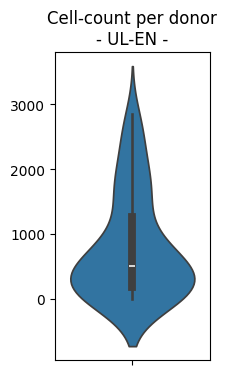

In [18]:
### By donor

donor_1ct = peaks_obs_1ct.groupby(['donor']).size()

p(stats.describe(donor_1ct))

plt.figure(figsize=(2,4))
sns.violinplot(donor_1ct)
plt.title(f"Cell-count per donor\n- {cell_type} -")

DescribeResult(nobs=4680, minmax=(0, 1326), mean=8.803418803418804, variance=3930.2947521477126, skewness=11.001051304973462, kurtosis=154.8698982025115)


Text(0.5, 1.0, 'Cell-count per donor-batch\n- UL-EN -')

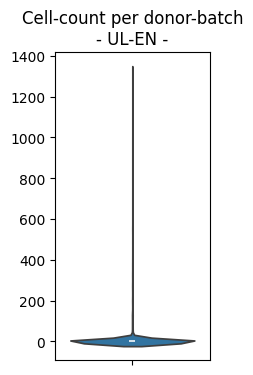

In [19]:
### By donor-batch

donor_1ct = peaks_obs_1ct.groupby(['donor', 'sample']).size()

p(stats.describe(donor_1ct))

plt.figure(figsize=(2,4))
sns.violinplot(donor_1ct)
plt.title(f"Cell-count per donor-batch\n- {cell_type} -")

# All cell-types

cell_type        DL-EN         Glia  Midbrain-EN  Neural-progenitors  \
count        72.000000    72.000000    72.000000           72.000000   
mean        419.583333   727.902778   268.500000          733.055556   
std         635.969654   737.351697   340.172036          932.072912   
min           0.000000     0.000000     0.000000            0.000000   
25%           3.750000   193.250000    12.750000            1.750000   
50%         141.500000   457.500000   117.000000          423.000000   
75%         550.750000   921.250000   383.250000          962.500000   
max        3129.000000  2615.000000  1446.000000         4166.000000   

cell_type        UL-EN  
count        72.000000  
mean        572.222222  
std         770.377779  
min           0.000000  
25%           0.000000  
50%         212.000000  
75%         752.000000  
max        2857.000000  


Text(0, 0.5, '#')

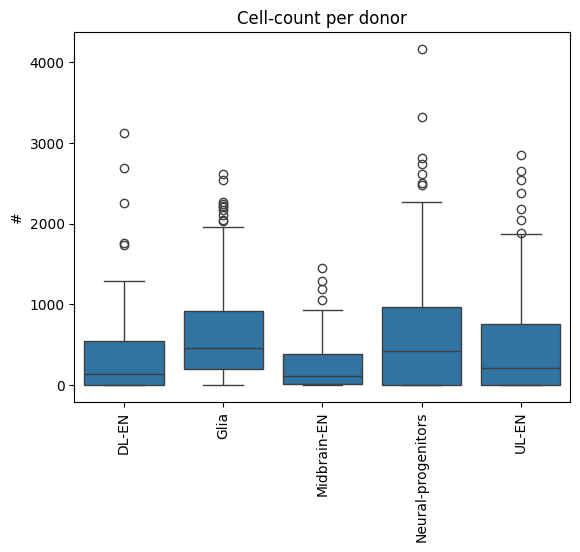

In [20]:
### By donor

donor_allcts = rna_obs.groupby(['cell_type', 'donor']).size().reset_index(level='cell_type')
donor_allcts_pivot = donor_allcts.pivot(columns='cell_type', values=0)

p(donor_allcts_pivot.describe())

sns.boxplot(data=donor_allcts, x='cell_type', y=0)
plt.xticks(rotation=90)
plt.title(f"Cell-count per donor")
plt.xlabel("")
plt.ylabel("#")

cell_type        DL-EN         Glia  Midbrain-EN  Neural-progenitors  \
count        66.000000    70.000000    69.000000           59.000000   
mean        457.727273   748.700000   280.173913          894.576271   
std         651.201813   737.326277   342.787619          957.339078   
min           1.000000    31.000000     1.000000            1.000000   
25%          10.750000   205.000000    16.000000          149.500000   
50%         240.000000   492.000000   124.000000          624.000000   
75%         556.750000   933.750000   390.000000         1087.000000   
max        3129.000000  2615.000000  1446.000000         4166.000000   

cell_type        UL-EN  
count        52.000000  
mean        792.307692  
std         805.248653  
min           1.000000  
25%         174.750000  
50%         500.500000  
75%        1266.750000  
max        2857.000000  


Text(0, 0.5, '#')

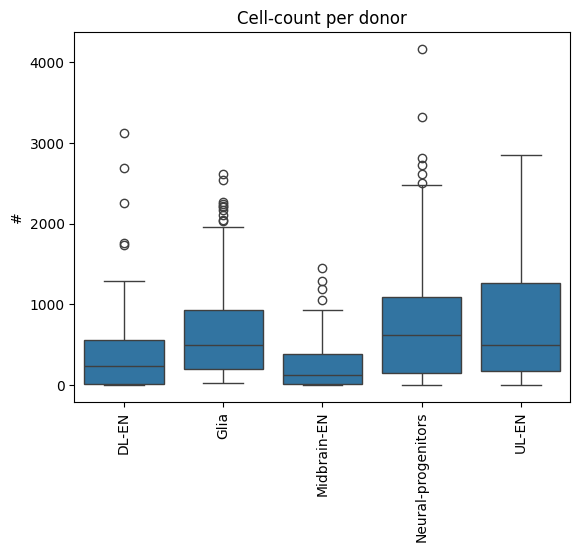

In [21]:
### By donor: 0s removed

donor_allcts = rna_obs.groupby(['cell_type', 'donor']).size().reset_index(level='cell_type')
donor_allcts = donor_allcts[~(donor_allcts[0] == 0)].copy()
donor_allcts_pivot = donor_allcts.pivot(columns='cell_type', values=0)

p(donor_allcts_pivot.describe())

sns.boxplot(data=donor_allcts, x='cell_type', y=0)
plt.xticks(rotation=90)
plt.title(f"Cell-count per donor")
plt.xlabel("")
plt.ylabel("#")

cell_type        DL-EN         Glia  Midbrain-EN  Neural-progenitors  \
count        93.000000    93.000000    93.000000           93.000000   
mean        324.838710   563.537634   207.870968          567.526882   
std         403.933736   534.196442   217.752963          560.487358   
min           0.000000    15.000000     3.000000            0.000000   
25%          64.000000   187.000000    68.000000          165.000000   
50%         182.000000   371.000000   140.000000          363.000000   
75%         438.000000   775.000000   270.000000          849.000000   
max        2010.000000  2526.000000  1367.000000         2660.000000   

cell_type        UL-EN  
count        93.000000  
mean        443.010753  
std         512.406566  
min           0.000000  
25%         103.000000  
50%         279.000000  
75%         604.000000  
max        2545.000000  


Text(0, 0.5, '#')

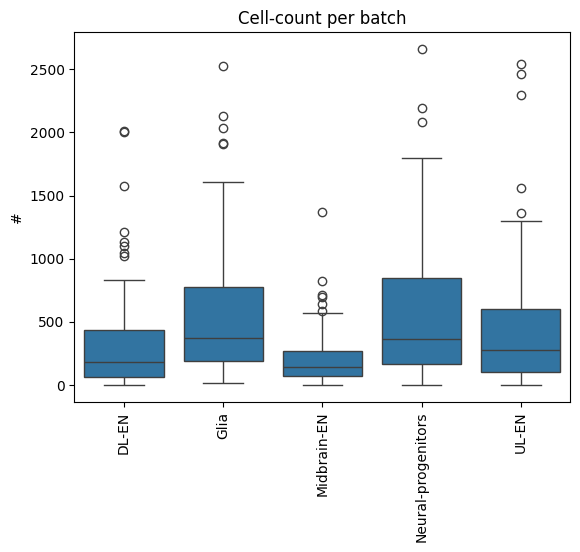

In [22]:
### By batch

batch_allcts = rna_obs.groupby(['cell_type', 'sample']).size().reset_index(level='cell_type')
batch_allcts_pivot = batch_allcts.pivot(columns='cell_type', values=0)

p(batch_allcts_pivot.describe())

sns.boxplot(data=batch_allcts, x='cell_type', y=0)
plt.xticks(rotation=90)
plt.title(f"Cell-count per batch")
plt.xlabel("")
plt.ylabel("#")

cell_type        DL-EN         Glia  Midbrain-EN  Neural-progenitors  \
count        92.000000    93.000000    93.000000           91.000000   
mean        328.369565   563.537634   207.870968          580.000000   
std         404.701483   534.196442   217.752963          560.189531   
min           1.000000    15.000000     3.000000            1.000000   
25%          64.000000   187.000000    68.000000          167.500000   
50%         183.000000   371.000000   140.000000          368.000000   
75%         439.750000   775.000000   270.000000          850.500000   
max        2010.000000  2526.000000  1367.000000         2660.000000   

cell_type        UL-EN  
count        90.000000  
mean        457.777778  
std         514.368420  
min          12.000000  
25%         122.000000  
50%         282.500000  
75%         607.750000  
max        2545.000000  


Text(0, 0.5, '#')

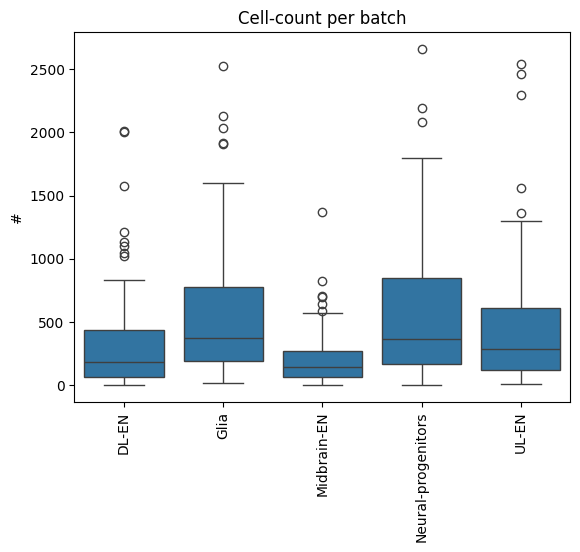

In [23]:
### By batch: 0s removed

batch_allcts = rna_obs.groupby(['cell_type', 'sample']).size().reset_index(level='cell_type')
batch_allcts = batch_allcts[~(batch_allcts[0] == 0)].copy()
batch_allcts_pivot = batch_allcts.pivot(columns='cell_type', values=0)

p(batch_allcts_pivot.describe())

sns.boxplot(data=batch_allcts, x='cell_type', y=0)
plt.xticks(rotation=90)
plt.title(f"Cell-count per batch")
plt.xlabel("")
plt.ylabel("#")

cell_type        DL-EN         Glia  Midbrain-EN  Neural-progenitors  \
count      6696.000000  6696.000000  6696.000000         6696.000000   
mean          4.511649     7.826912     2.887097            7.882318   
std          40.094573    57.248515    25.927407           61.709582   
min           0.000000     0.000000     0.000000            0.000000   
25%           0.000000     0.000000     0.000000            0.000000   
50%           0.000000     0.000000     0.000000            0.000000   
75%           0.000000     0.000000     0.000000            0.000000   
max        1165.000000  1495.000000   683.000000         1499.000000   

cell_type        UL-EN  
count      6696.000000  
mean          6.152927  
std          52.565332  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           0.000000  
max        1326.000000  


Text(0.5, 1.0, 'Cell-count per donor-batch')

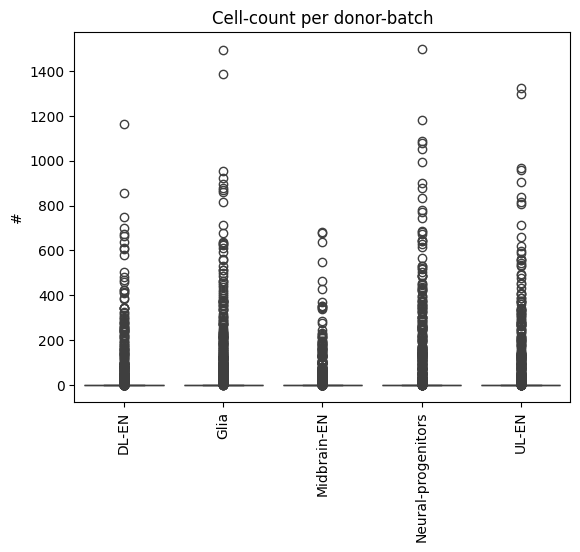

In [24]:
### By donor-batch:
donor_batch_allcts = rna_obs.groupby(['cell_type', 'donor', 'sample']).size().reset_index(level=['cell_type', 'sample', 'donor'])
donor_batch_allcts['donor_batch'] = donor_batch_allcts['donor'].astype(str) + "_" + donor_batch_allcts['sample'].astype(str)
donor_batch_allcts = donor_batch_allcts[['cell_type', 0, 'donor_batch']].set_index('donor_batch')
donor_batch_allcts

donor_batch_allcts_pivot = donor_batch_allcts.pivot(columns='cell_type', values=0)

p(donor_batch_allcts_pivot.describe())

sns.boxplot(data=donor_batch_allcts, x='cell_type', y=0)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("#")
plt.title(f"Cell-count per donor-batch")

cell_type        DL-EN         Glia  Midbrain-EN  Neural-progenitors  \
count       277.000000   380.000000   278.000000          238.000000   
mean        109.061372   137.918421    69.539568          221.764706   
std         165.987012   199.763557   107.684139          244.831233   
min           1.000000     1.000000     1.000000            1.000000   
25%           5.000000    22.000000     5.000000           50.500000   
50%          38.000000    59.500000    27.000000          141.500000   
75%         143.000000   171.250000    95.750000          302.000000   
max        1165.000000  1495.000000   683.000000         1499.000000   

cell_type        UL-EN  
count       220.000000  
mean        187.272727  
std         224.492463  
min           1.000000  
25%          33.750000  
50%         111.500000  
75%         268.250000  
max        1326.000000  


Text(0.5, 1.0, 'Cell-count per donor-batch')

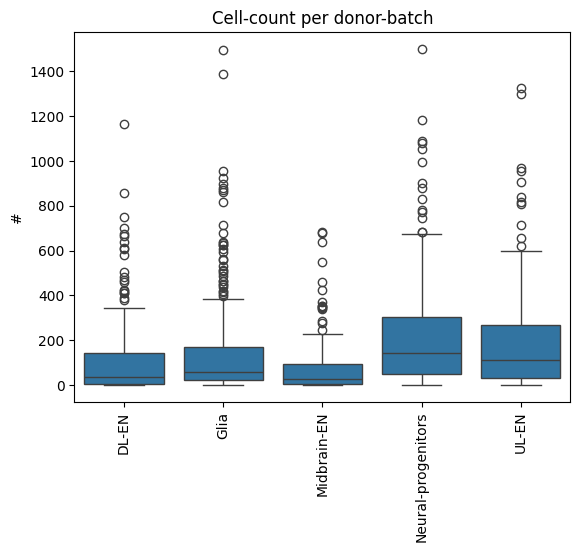

In [25]:
### By donor-batch: 0s removed

donor_batch_allcts = rna_obs.groupby(['cell_type', 'donor', 'sample']).size().reset_index(level=['cell_type', 'sample', 'donor'])
donor_batch_allcts = donor_batch_allcts[~(donor_batch_allcts[0] == 0)].copy()
donor_batch_allcts['donor_batch'] = donor_batch_allcts['donor'].astype(str) + "_" + donor_batch_allcts['sample'].astype(str)
donor_batch_allcts = donor_batch_allcts[['cell_type', 0, 'donor_batch']].set_index('donor_batch')
donor_batch_allcts

donor_batch_allcts_pivot = donor_batch_allcts.pivot(columns='cell_type', values=0)

p(donor_batch_allcts_pivot.describe())

sns.boxplot(data=donor_batch_allcts, x='cell_type', y=0)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("#")
plt.title(f"Cell-count per donor-batch")